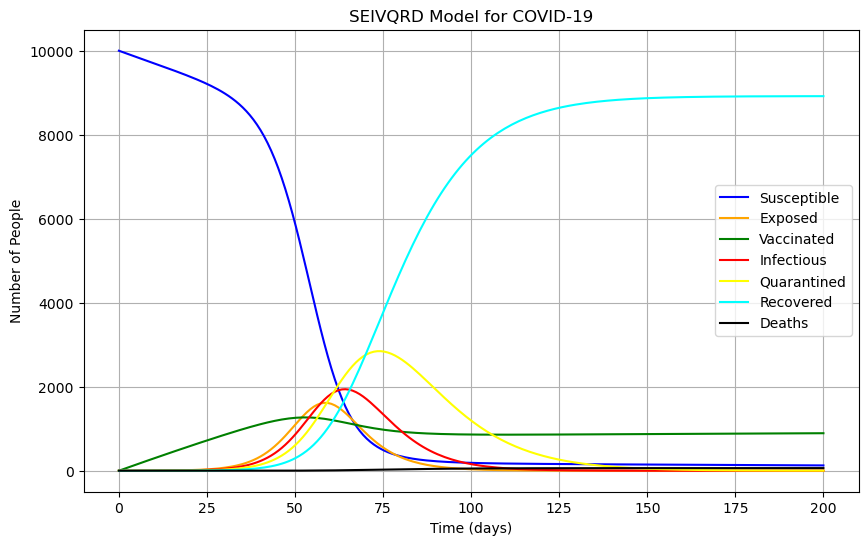

people who died from the covid-19 62.419658018270795


In [26]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

# Initial conditions
S_0 = 9999  # Initial value for susceptible individuals
E_0 = 1    # Initial value for exposed individuals
I_0 = 0    # Initial value for infectious individuals
Q_0 = 0    # Initial value for quarantined individuals
R_0 = 0    # Initial value for recovered individuals
D_0 = 0    # Initial value for deaths
V_0 = 0    # Initial value for vaccinated individuals

N_0 = S_0 + E_0 + I_0 + Q_0 + R_0 + D_0 + V_0 # Total population

# Constant Parameters

lambda_capital = 0  # Birth/new resident rate per day 
beta = 0.6  # Transmission rate 
alpha = 0.003  # Vaccination rate per day  
mu = 0  # Natural death rate per day
sigma = 0.1  # Vaccine inefficacy rate
gamma = 1/5  # Rate of progression from exposed to infectious (1/latent period)
delta = 1/7  # Rate of quarantine (1/quarantine period)
kappa = 0.01  # Mortality rate among infected
lambda_recovery = 1/14  # Recovery time rate (1/recovery period)
rho = 1/20  # Death time rate among infected (1/death period)

# Time (in days)
t = np.linspace(0, 200, 200)

# The Differential Equations of the SIR Model
def deriv_seivqrd(y, t, lambda_capital, mu, alpha, beta, sigma, gamma, delta, lambda_recovery, rho, kappa, N):
    S, E, V, I, Q, R, D = y
    
    dSdt = lambda_capital - beta * S * I / N - alpha * S - mu * S
    dEdt = beta * S * I / N + sigma * V * I / N - gamma * E
    dVdt = alpha * S - sigma * V * I / N
    dIdt = gamma * E - delta * I
    dQdt = delta * I - (lambda_recovery + rho * kappa) * Q
    dRdt = lambda_recovery * Q
    dDdt = rho * kappa * Q
    
    return dSdt, dEdt, dVdt, dIdt, dQdt, dRdt, dDdt

# Initial vector of conditions
y0 = S_0, E_0, V_0, I_0, Q_0, R_0, D_0

# Integrate the SEIVQRD equations over the time grid, t
result = odeint(deriv_seivqrd, y0, t, args=(lambda_capital, mu, alpha, beta, sigma, gamma, delta, lambda_recovery, rho, kappa, N_0))

S, E, V, I, Q, R, D = result.T

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', color='blue')
plt.plot(t, E, label='Exposed', color='orange')
plt.plot(t, V, label='Vaccinated', color='green')
plt.plot(t, I, label='Infectious', color='red')
plt.plot(t, Q, label='Quarantined', color='yellow')
plt.plot(t, R, label='Recovered', color='cyan')
plt.plot(t, D, label='Deaths', color='black')

plt.xlabel('Time (days)')
plt.ylabel('Number of People')
plt.title('SEIVQRD Model for COVID-19')
plt.legend()
plt.grid(True)
plt.show()

print('people who died from the covid-19',D[-1])

In [ ]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Define the main class for the Disease Spread Simulation Application
class DiseaseSpreadSimulationApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Disease Spread Simulation")  # Set the window title
        self.geometry("900x600")  # Set the window size

        # Initialize simulation parameters
        self.parameters = {
            "Population Size": 200,  # Total number of people in the simulation
            "Space Size": 15,  # Size of the simulation area (square)
            "Initial Infections": 1,  # Number of initially infected individuals
            "Average Recovery Time": 10,  # Average time it takes for an infected person to recover
            "Infection Probability": 0.35,  # Probability of infection on contact
            "Contact Radius": 0.2,  # Radius within which infection can occur
            "Immunity Duration": 30,  # Duration of immunity after recovery
            "Daily Vaccination Rate": 0.3,  # Percentage of susceptible population vaccinated per day
            "Mask Threshold": 25,  # Threshold of infected population to start mask usage
            "Social Distancing Threshold": 50  # Threshold of infected population to enforce social distancing
        }

        self.init_ui()  # Initialize the user interface

    def init_ui(self):
        row = 0
        self.entries = {}
        # Create entry fields for all parameters
        for param, value in self.parameters.items():
            label = param.replace("_", " ")  # Replace underscores with spaces for labels
            ttk.Label(self, text=label).grid(column=0, row=row, sticky=tk.W, padx=10, pady=5)
            entry_var = tk.DoubleVar(value=value)
            entry = ttk.Entry(self, textvariable=entry_var, width=10)
            entry.grid(column=1, row=row, sticky=tk.EW, padx=10, pady=5)
            self.entries[param] = entry_var
            row += 1

        # Button to start the simulation
        self.start_button = ttk.Button(self, text="Start Simulation", command=self.start_simulation)
        self.start_button.grid(column=0, row=row, columnspan=2, pady=10, sticky=tk.EW, padx=10)
        
        # Add the density label after all other UI elements
        row += 1
        self.density_label = ttk.Label(self, text="Density: Calculating...")
        self.density_label.grid(column=0, row=row, columnspan=2, sticky=tk.W, padx=10, pady=5)

    def setup_simulation(self, params):
        # Initialize simulation variables based on user input
        self.population_size = int(params["Population Size"])
        self.space_size = float(params["Space Size"])
        self.initial_infections = int(params["Initial Infections"])
        self.prob_infection = float(params["Infection Probability"])
        self.contact_radius = float(params["Contact Radius"]) ** 2
        self.infection_time = np.zeros(self.population_size)

        self.average_recovery_time = int(params["Average Recovery Time"]) * 24
        self.immunity_duration = int(params["Immunity Duration"]) * 24
        self.daily_vaccination_rate = float(params["Daily Vaccination Rate"])
        self.current_vaccinated = 0  # Track the number of vaccinated individuals
        self.total_population_vaccinated_limit = int(0.5 * self.population_size)  # Maximum 50% of population can be vaccinated

        self.states = np.zeros(self.population_size, dtype=int)
        self.states[:self.initial_infections] = 1
        self.positions = np.random.rand(self.population_size, 2) * self.space_size
        self.directions = (np.random.rand(self.population_size, 2) - 0.5) * 0.5

        self.fig, self.ax = plt.subplots()
        self.scat = self.ax.scatter(self.positions[:, 0], self.positions[:, 1], c=self.get_colors(), s=8)
        self.ax.set_xlim(0, self.space_size)
        self.ax.set_ylim(0, self.space_size)
        self.init_sirv_graph()

    def get_colors(self):
        # Return color based on the state of each individual
        return ['blue' if state == 0 else 'red' if state == 1 else 'green' if state == 2 else 'purple' for state in self.states]

    def update_animation(self, frame):
        """
        This method updates the state of the simulation for each frame.
        It handles movement, infection processes, recovery, and the enforcement of health measures.
        """
        # Update the directions of individuals every 10 frames to simulate random movement
        if frame % 10 == 0:
            self.directions = (np.random.rand(self.population_size, 2) - 0.5) * 0.5
        # Update positions based on directions; ensure they stay within the space boundaries using modulo operation
        self.positions += self.directions
        self.positions %= self.space_size

        # Calculate the current infection rate as a percentage of the population
        infected_count = np.sum(self.states == 1)
        infection_rate = (infected_count / self.population_size) * 100

        # Adjust infection probability based on mask usage
        # If the infection rate exceeds the mask threshold, reduce the infection probability
        if infection_rate > self.entries['Mask Threshold'].get():
            current_infection_probability = self.prob_infection / 2
        else:
            current_infection_probability = self.prob_infection

        # Adjust the contact radius for social distancing
        # If the infection rate exceeds the social distancing threshold, increase the contact radius
        # which effectively reduces the number of close contacts each individual has
        if infection_rate > self.entries['Social Distancing Threshold'].get():
            effective_contact_radius = self.contact_radius * 0.5
        else:
            effective_contact_radius = self.contact_radius

        # Infection process: loop through all individuals
        for i in range(self.population_size):
            if self.states[i] == 1:  # Check if this individual is infected
                for j in range(self.population_size):  # Loop through all other individuals
                    if self.states[j] == 0:  # Check if they are susceptible
                        distance_squared = np.sum((self.positions[i] - self.positions[j])**2)
                        if distance_squared <= effective_contact_radius:  # Check if within infection range
                            distance = np.sqrt(distance_squared)
                            max_distance = np.sqrt(effective_contact_radius)
                            # Calculate infection probability based on distance
                            adjusted_prob_infection = current_infection_probability * (1 - distance / max_distance)
                            if np.random.rand() < adjusted_prob_infection:
                                self.states[j] = 1  # Infect the susceptible individual
                                self.infection_time[j] = 0  # Start their infection timer

        # Recovery and immunity handling
        for i in range(self.population_size):
            if self.states[i] == 1:  # Infected
                self.infection_time[i] += 1
                if self.infection_time[i] >= self.average_recovery_time:
                    self.states[i] = 2  # Recovered
                    self.infection_time[i] = 0  # Reset infection timer for recovery

            elif self.states[i] == 2:  # Recovered
                self.infection_time[i] += 1
                if self.infection_time[i] >= self.immunity_duration:
                    self.states[i] = 0  # Become susceptible again
                    self.infection_time[i] = 0  # Reset immunity timer
                    
        

        # Vaccination process: check every 7 days (168 frames at 24 frames per day)
        if frame % (24 * 7) == 0:
            if self.current_vaccinated < self.total_population_vaccinated_limit:
                susceptible_indices = np.where(self.states == 0)[0]
                number_to_vaccinate_today = int(self.daily_vaccination_rate * 0.01 * len(susceptible_indices))
                if number_to_vaccinate_today > 0:
                    if self.current_vaccinated + number_to_vaccinate_today > self.total_population_vaccinated_limit:
                        number_to_vaccinate_today = self.total_population_vaccinated_limit - self.current_vaccinated
                    vaccinated_indices = np.random.choice(susceptible_indices, size=number_to_vaccinate_today, replace=False)
                    self.states[vaccinated_indices] = 3  # Update state to vaccinated
                    self.current_vaccinated += number_to_vaccinate_today  # Increment the vaccinated count

        # Update the scatter plot to reflect changes
        self.scat.set_offsets(self.positions)
        self.scat.set_color(self.get_colors())
        self.update_sirv_graph(frame)
        self.canvas.draw()
        self.calculate_density()
        
    def calculate_density(self):
        area = self.space_size ** 2
        density = self.population_size / area
        density_text = f"Density: {density:.2f} people per unit area"
        self.density_label.config(text=density_text)


    def init_sirv_graph(self):
        # Initialize the graph that shows SIRV data over time
        self.sirv_fig, self.sirv_ax = plt.subplots()
        self.sirv_data = {'S': [], 'I': [], 'R': [], 'V': [], 'time': []}
        self.s_line, = self.sirv_ax.plot([], [], label='Susceptible', color='blue')
        self.i_line, = self.sirv_ax.plot([], [], label='Infected', color='red')
        self.r_line, = self.sirv_ax.plot([], [], label='Recovered', color='green')
        self.v_line, = self.sirv_ax.plot([], [], label='Vaccinated', color='purple')
        self.sirv_ax.legend()
        self.sirv_ax.set_xlim(0, 250)  # Duration of simulation in days
        self.sirv_ax.set_ylim(0, self.population_size)

    def update_sirv_graph(self, frame):
        # Update the SIRV graph based on the current simulation frame
        if frame % 24 == 0:
            current_day = frame // 24
            S = np.sum(self.states == 0)
            I = np.sum(self.states == 1)
            R = np.sum(self.states == 2)
            V = np.sum(self.states == 3)
            self.sirv_data['S'].append(S)
            self.sirv_data['I'].append(I)
            self.sirv_data['R'].append(R)
            self.sirv_data['V'].append(V)
            self.sirv_data['time'].append(current_day)
            self.s_line.set_data(self.sirv_data['time'], self.sirv_data['S'])
            self.i_line.set_data(self.sirv_data['time'], self.sirv_data['I'])
            self.r_line.set_data(self.sirv_data['time'], self.sirv_data['R'])
            self.v_line.set_data(self.sirv_data['time'], self.sirv_data['V'])
            self.sirv_ax.relim()
            self.sirv_ax.autoscale_view(True, True, True)
            self.sirv_canvas.draw()

    def start_simulation(self):
        # Start the simulation using the parameters provided by the user
        params = {param: var.get() for param, var in self.entries.items()}
        self.setup_simulation(params)
        self.canvas = FigureCanvasTkAgg(self.fig, master=self)
        self.canvas.get_tk_widget().grid(column=2, row=0, rowspan=12, sticky="nsew")
        self.sirv_canvas = FigureCanvasTkAgg(self.sirv_fig, master=self)
        self.sirv_canvas.get_tk_widget().grid(column=3, row=0, rowspan=12, sticky="nsew")
        self.ani = FuncAnimation(self.fig, self.update_animation, frames=np.arange(0, 6000), interval=100, repeat=False)
        self.canvas.draw()
        self.sirv_canvas.draw()

if __name__ == "__main__":
    app = DiseaseSpreadSimulationApp()
    app.mainloop()
